In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import tensorflow_probability as tfp
import tensorflow.keras as tfk
import pymc as pm
from sklearn.metrics import mean_squared_error, r2_score
import arviz as az

In [2]:
# Read in data
layoffs_df = pd.read_csv('layoffs.csv')

# Observe the initial dataframe dimensions
print(f"Number of initial feature columns: {len(layoffs_df.columns)}")
print(f"Number of initial observations: {len(layoffs_df)}")

# Convert data to the correct datatypes
layoffs_df['company']  = layoffs_df['company'].astype('string')
layoffs_df['location']  = layoffs_df['location'].astype('string')
layoffs_df['industry'] = layoffs_df['industry'].astype('string')
layoffs_df['date'] = pd.to_datetime(layoffs_df['date'])
layoffs_df['stage'] = layoffs_df['stage'].astype('string')
layoffs_df['country'] = layoffs_df['country'].astype('string')

# Remove observations with at least one feature missing, or with unknown stage
layoffs_df = layoffs_df[layoffs_df['stage'] != 'Unknown']
# Also removing location (implicity covered by "country")
layoffs_df = layoffs_df.drop('location', axis=1)
# Also removing the names of companies (should not be important for our analysis)
layoffs_df = layoffs_df.drop('company', axis=1)

layoffs_df = layoffs_df.dropna()

# Chunking dates into quarters
# Compute the number of months since the minimum year and month
years = layoffs_df['date'].dt.year
months = layoffs_df['date'].dt.month

min_date = layoffs_df['date'].min()
chunks = (years - min_date.year) * 12 + (months - min_date.month)

# Add the chunk column if needed
layoffs_df['date'] = chunks

# Chunking stages
mapping = {
    'Seed': 'Early Stage',
    'Series A': 'Early Stage',
    'Series B': 'Growth Stage',
    'Series C': 'Growth Stage',
    'Series D': 'Growth Stage',
    'Series E': 'Growth Stage',
    'Series F': 'Growth Stage',
    'Series G': 'Growth Stage',
    'Series H': 'Growth Stage',
    'Series I': 'Growth Stage',
    'Series J': 'Growth Stage',
    'Post-IPO': 'Post-IPO',
    'Private Equity': 'Post-IPO',
    'Acquired': 'Acquired / Subsidiary',
    'Subsidiary': 'Acquired / Subsidiary',
}
layoffs_df['stage'] = layoffs_df['stage'].map(lambda stage: mapping.get(stage))

# One-hot encoding
layoffs_df = pd.get_dummies(layoffs_df, drop_first=True, dtype = int)

# Observe the new dataframe dimensions
print(f"Number of feature columns after cleaning: {len(layoffs_df.columns)}")
print(f"Number of observations after cleaning: {len(layoffs_df)}")



Number of initial feature columns: 9
Number of initial observations: 3101
3101
1348
Number of feature columns after cleaning: 1312
Number of observations after cleaning: 1348


In [3]:
X = layoffs_df.drop(columns=['percentage_laid_off'], axis=1)
y = layoffs_df['percentage_laid_off']

X_scaled = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)


In [4]:
mae = mean_absolute_error(y_test, mean_preds)
mse = mean_squared_error(y_test, mean_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, mean_preds)

print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

In [12]:
eps = 1e-4  # Small value to push away from 0 and 1
y_train_transformed = (y_train * (1 - 2 * eps)) + eps

with pm.Model() as model:
    # Priors for regression coefficients
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])  # Normal prior for the coefficients
    alpha = pm.Normal('alpha', mu=0, sigma=10)  # Intercept with a normal prior

    # Logistic regression (logit of the Beta distribution)
    logit_mu = alpha + pm.math.dot(X_train, beta)

    # Transform the linear model to the [0, 1] range using the logistic function
    mu = pm.math.sigmoid(logit_mu)  # Sigmoid ensures values between 0 and 1

    # Priors for the Beta distribution parameters (alpha and beta)
    alpha_beta = pm.Gamma('alpha_beta', alpha=1, beta=1)
    beta_beta = pm.Gamma('beta_beta', alpha=1, beta=1)

    # Beta likelihood for the proportion (percentage laid off)
    likelihood = pm.Beta('y', alpha=mu * alpha_beta, beta=(1 - mu) * beta_beta, observed=y_train_transformed)

    # Sampling from the posterior distribution
    trace = pm.sample(1000, target_accept=0.95, return_inferencedata=True)





Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, alpha_beta, beta_beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1086 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [y]


Output()

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

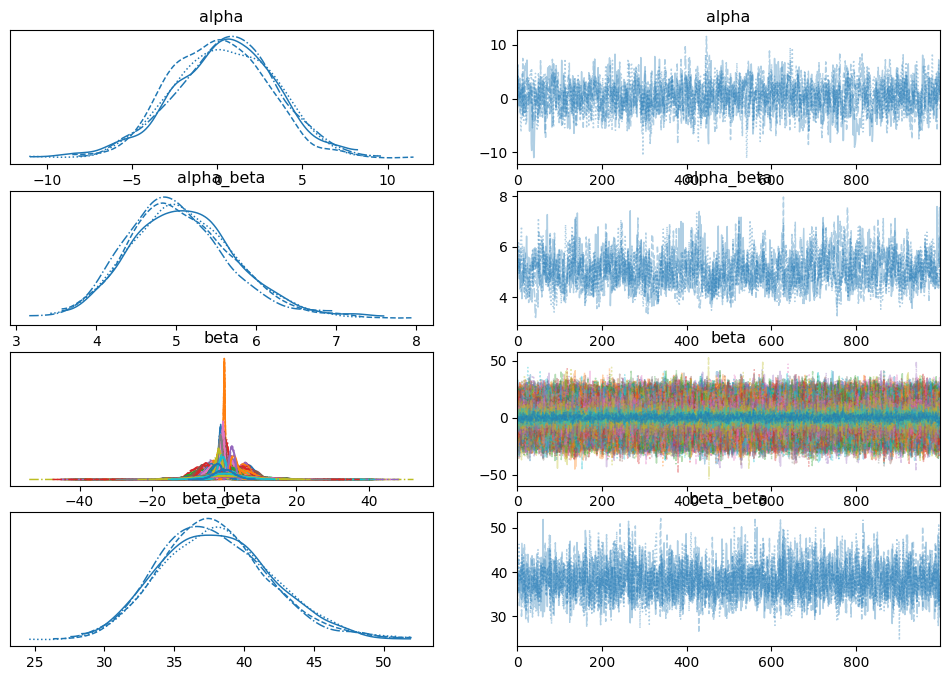

In [17]:
az.summary(trace)
az.plot_trace(trace)